### Stochastic Fokker-Planck integration of spiking neural network
##### Gianni V. Vinci

In [1]:
import SFP
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import welch



In [22]:
# Parameters of the integration
dt=0.01/1000                             #[s]  Integration time step
T=60                                     #[s]  Simulation life time  
N_V=1000                                 #     Numbert of grid point in potential discretization


Vt,Vr,Vmin=20.,0.,-3*20.                 #[mV] Trheshold,Reset and minimum potential   
TauV=0.02                                #[s]  Membrane time constant
TauD=0.001                               #[s]  Characteristic time of exponential delay distribution
delta=0.002                              #[s]  Constant axonal delay
tref=0                                   #[s]  Absolute refracory time

Mu0,Sig0=21,2.6652                       #[mV] Mean and variace of synaptic current multiplied by TauV and sqrt(TauV)
R0=20                                    #[Hz] Stationary firing rate
N=10000                                  #     Number of neurons, Possible choices at the moment N:1000,10000,100000
K=1000                                   #     Mean synaptic contacts per neuron     
J=10/K                                   #[mV] Strenght of synaptic coupling 



# Initialize routine for finite size noise given the number of neuron 
IntegrateEta=SFP.InitializeEta(N)

#Store parameters in dictionary
Net={'dt':dt,'Vt':Vt,'Vr':Vr,'Vmin':Vmin,'N_V':N_V,'K':K,'J':J,
     'Mu0':Mu0,'R0':R0,'Sig0':Sig0,'TauV':TauV,'IExt':0.0,'delta':delta,'tref':tref,
     'Life':T,'N':N,'TauD':TauD,'delay_type':3,'gC':0.0,'AlphaC':0.0,"TauC":1.0}

#Readjust the external current to have the stationary firing rate at R0
Net['MuExt'],Net['SigExt']=SFP.ExternalCurrent(Net)

#Initialize the grid for the Fokker-Planck
grid =SFP.Grid(V_0=Net['Vmin'], V_1=Net['Vt'], V_r=Net['Vr'],N_V=Net['N_V'])





In [23]:
def Simulate(Net):

    T,dt=Net["Life"],Net["dt"]
    tref,delta=Net["tref"],Net["delta"]
    TauV,TauD=Net["TauV"], Net["TauD"]
    
    Steps=int(T/dt)
    rN=np.zeros(Steps)
    r=np.zeros_like(rN)
    t=np.linspace(0,T,Steps)
    nd=int(delta/dt)
    n_ref=int(tref/dt)

    #Initialize probability distribution
    Net['fp_v_init']='delta'
    p=SFP.initial_p_distribution(grid,Net)
    r_d=rN[nd]
    Eta,u1,u2=0,0,0
    ts=time.time()
    for n in range(nd+n_ref,Steps-1):
        #Update the mean and variance of the synaptic current
        mu_tot=K*J*r_d +Net['MuExt']
        sigma_tot=np.sqrt(K * J ** 2 * r_d + Net['SigExt'] ** 2)
        int_ref = np.sum(r[n-n_ref:n]*dt) 

        # Generate finite-soze noise via Markovian embedding
        Z=np.random.randn() 
        Eta,u1,u2=IntegrateEta(dt,Z,Eta,u1,u2,r[n],N,mu_tot*TauV,sigma_tot*TauV)
        InPut={'r_d':r_d,'rND':rN[n-nd],'p':p,'mu_tot':mu_tot,'sigma_tot':sigma_tot,'TauD':TauD,
               'Eta':Eta,'dt':dt,'TauV':TauV,'int_ref':int_ref,'rNref':rN[n-n_ref]}

        #Integrate the F.P equation for one step
        r_d,rN[n+1],r[n+1],p=SFP.IntegrateFP(InPut,grid)
    te=time.time()
    print('Integration done in  %3d s'%(te-ts))
    return t,rN


In [24]:
t,rN=Simulate(Net)

Integration done in  852 s


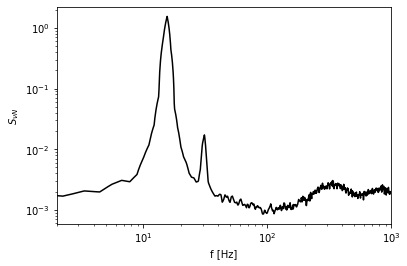

In [36]:
fs=1/Net["dt"]
Ind=np.abs(t-1).argmin()
nFreq=90000
f, Pxx_den = welch(rN[Ind:], fs, nperseg=nFreq,return_onesided=True)
F=np.logspace(0,3,1000)
S=np.interp(F,f,Pxx_den/2)
plt.loglog(F,S,"-k")
plt.xlabel("f [Hz]")
plt.ylabel(r"$S_{\nu N}$")
plt.xlim(2,1000);